In [11]:
!pip install seirsplus networkx==2.8

In [12]:
import networkx as nx
import random
import itertools

N_PASS = 2700
P_C_RATIO = 2.5
N_CREW = int(2700 / P_C_RATIO)

# Saturating the weights between nodes to follow the exponential distribution.
# Risk increases with longer contact but gets saturated after certain point
def add_saturation_weight(duration_min, total_duration_min=180):
    duration_days = duration_min / (24 * 60)  
    total_days = total_duration_min / (24 * 60)
    return 1 - np.exp(-duration_days / total_days)
        

# Creating function to default to max edge weight for overlapping connections
def add_cummulative_weight(G, u, v, duration):
    if G.has_edge(u, v):
        G[u][v]['cum_duration'] += duration
    else:
        G.add_edge(u, v, cum_duration=duration)
    G[u][v]['weight'] = add_saturation_weight(G[u][v]['cum_duration'])



def build_cruise_graph(n_passengers=N_PASS, passengers_per_cabin=2, passenger_crew_ratio=P_C_RATIO):
    random.seed(123) # for reproducibility
    """
    Set the high-level cruise occupant parameters to correspond to industry averages

    Graph below establishes connections based on:
      - Shared cabins between passengers
      - Shared decks between passengers
      - Shared dinner table between passengers
      - Crew-to-passenger interactions
      - Shared cabins between crew
      - Shared workspaces between crew

    The weights are based on my take on interaction frequency - happy to tweak as necessary

    Layers to add (optional)"
      - Age demographics (will increase complication for other elements of the simulation)
    """

    G = nx.Graph()

    n_crew = int(n_passengers / passenger_crew_ratio)
    total_nodes = n_passengers + n_crew

    G.add_nodes_from(range(total_nodes))

    # Adding labels for each passenger
    for i in range(n_passengers):
        G.nodes[i]['type'] = 'passenger'
        G.nodes[i]['id'] = i
        G.nodes[i]['cabin_id'] = i // passengers_per_cabin

    # Adding labels and categories for each crew member
    for i in range(n_passengers, total_nodes):
        crew_id = i
        crew_type = 'passenger_service' if i < n_passengers + int(0.7 * n_crew) else 'non_service'

        G.nodes[i]['type'] = 'crew'
        G.nodes[i]['crew_type'] = crew_type
        G.nodes[i]['id'] = crew_id

    # Pairing two passengers in each cabin
    for i in range (0, n_passengers, passengers_per_cabin):
        cabin = list(range(i, min(i + passengers_per_cabin, n_passengers)))
        for u in cabin:
            for v in cabin:
                if u != v:
                    duration = random.uniform(360, 480) # saturation point is 180m min
                    add_cummulative_weight(G,u,v,duration)

    # Creating the dining cohorts
    n_cohorts = 9
    cohort_size = n_passengers // n_cohorts

    for cohort_num in range(n_cohorts):
        start = cohort_num * cohort_size
        end = (cohort_num + 1) * cohort_size if cohort_num < n_cohorts - 1 else n_passengers
        cohort_passengers = list(range(start, end))

        # Creating tables of 8 passengers each, randomly assigned
        random.shuffle(cohort_passengers)

        for i in range(0, len(cohort_passengers), 8):
            table = cohort_passengers[i:i+8]
            for u in table:
                for v in table:
                    if u != v:
                        duration = random.uniform(35, 90) # average dining time around 67 mins
                        add_cummulative_weight(G,u,v,duration)

    # Creating deck-level groups for moderate interaction
    n_decks = 17

    passengers_per_deck = n_passengers // n_decks
    for i in range(n_passengers):
        G.nodes[i]['deck'] = i // passengers_per_deck

    for deck_num in range(n_decks):
        deck_passengers = [i for i in range(n_passengers) if G.nodes[i]['deck'] == deck_num]

        random.shuffle(deck_passengers)

        for i in range(len(deck_passengers)):
            u = deck_passengers[i]
            for _ in range(10):
                v = random.choice(deck_passengers)
                if u != v:
                    duration = random.uniform(10, 240)
                    add_cummulative_weight(G,u,v,duration)
                    

    # Creating transient connections between passengers across the whole ship
    for i in range(n_passengers):
        contacts = random.sample(range(n_passengers), 25)
        for j in contacts:
            if i != j:
                duration = random.uniform(0, 15) # short encounter
                add_cummulative_weight(G,i,j,duration)

    # Connecting passenger_service crew to passengers
    for i in range(n_passengers, total_nodes):
        if G.nodes[i]['crew_type'] == 'passenger_service':
            served_passengers = random.sample(range(n_passengers), 50)
            for p in served_passengers:
                duration = random.uniform(0, 30) # short service
                add_cummulative_weight(G,i,j,duration)

    # Adding weak connection between non-service crew and passengers
    for i in range(n_passengers, total_nodes):
          if G.nodes[i]['crew_type'] == 'non_service':
              served_passengers = random.sample(range(n_passengers), 10)
              for p in served_passengers:
                  duration = random.uniform(0, 3) # rare encounter
                  add_cummulative_weight(G,u,v,duration)

    # Adding crew-to-crew edges (cabinmates and shared category)
    crew_ids = list(range(n_passengers, total_nodes))

    for i in range(0, len(crew_ids), 2):
        cabin = crew_ids[i:i+2]
        for u in cabin:
            for v in cabin:
                if u != v:
                    duration = random.uniform(360, 480) # almost like cabinmates
                    add_cummulative_weight(G,u,v,duration)

    service_crew = [i for i in crew_ids if G.nodes[i]['crew_type'] == 'passenger_service']
    non_service_crew = [i for i in crew_ids if G.nodes[i]['crew_type'] == 'non_service']

    for crew_group in [service_crew, non_service_crew]:
        for u in crew_group:
            peers = random.sample(crew_group, 30)
            for v in peers:
                if u != v:
                    duration = random.uniform(30, 120) # less than sharing cabins
                    add_cummulative_weight(G,u,v,duration)

    # adding shared facilities where all passengers and crews (regardless of type) can be at multiple times in a day
    shared_facilities = {"lounge":{"count": 6, "size": 30, "duration": (40, 90), "repeats": 3}, 
                         "pool":{"count": 4, "size": 20, "duration": (15, 60), "repeats": 2},
                         "jacuzzi":{"count": 8, "size": 12,  "duration": (10, 20), "repeats": 2},
                         "elevator":{"count": 14, "size": 8,"duration": (1, 3),"repeats": 10}}
    
    passengers = [n for n, d in G.nodes(data=True) if d['type'] == 'passenger']
    crews = [n for n, d in G.nodes(data=True) if d['type'] == 'crew']
    
    for name,desc in shared_facilities.items():
        for i in range(desc["count"]): 
            for j in range(desc["repeats"]):
                size = desc["size"]
                n_pass = min(round(size * 0.9), len(passengers))
                n_crew_p = min(size - n_pass, len(service_crew))
                users = random.sample(passengers,n_pass) + random.sample(service_crew,n_crew_p) 
                for u, v in itertools.combinations(users, 2):
                    duration = random.uniform(*desc["duration"]) 
                    add_cummulative_weight(G, u, v, duration)  

    return G, n_passengers

# # Superspreader event like Casino, Movie Night
# def add_super_spreader_event(G, event_size=80, duration_min=120):
#     crew_ids = list(range(N_PASS, N_PASS+N_CREW))
#     passengers = [n for n, d in G.nodes(data=True) if d['type'] == 'passenger']
#     service_crew = [i for i in crew_ids if G.nodes[i]['crew_type'] == 'passenger_service']
    
#     n_pass = int(event_size * 0.8)
#     n_crew = event_size - n_pass  # Ensure total stays at event_size

#     participants = random.sample(passengers, n_pass) + random.sample(service_crew, n_crew)

#     for i in range(len(participants)):
#         for j in range(i + 1, len(participants)):
#             u = participants[i]
#             v = participants[j]
#             add_cummulative_weight(G, u, v, duration_min)
            

def build_quarantine_graph(G, n_passengers, seed=123):
    """
    This subgraph basically shuts down connections and confines people to cabins

    There's also some crew-to-crew interaction to keep the ship running
    """
    random.seed(seed)
    G_Q = nx.Graph()
    G_Q.add_nodes_from(G.nodes(data=True))

    total_nodes = len(G.nodes)

    for u in G_Q.nodes():
        u_type = G_Q.nodes[u]['type']

        if u_type == 'passenger':
            cabin_id = G_Q.nodes[u]['cabin_id']
            cabinmates = [v for v in range(n_passengers)
                          if v != u and G.nodes[v]['cabin_id'] == cabin_id]

        elif u_type == 'crew':
            crew_index = u - n_passengers
            bunkmate_index = crew_index ^ 1
            bunkmate = n_passengers + bunkmate_index

            if bunkmate != u and bunkmate < total_nodes:
                cabinmates = [bunkmate]
            else:
                  cabinmates = []

        else:
            cabinmates = []

        for v in cabinmates:
            if not G_Q.has_edge(u, v):  
                G_Q.add_edge(u, v, weight=1.0, source='cabin')

    crew_ids = range(n_passengers, total_nodes)
    service_crew = [i for i in crew_ids if G_Q.nodes[i]['crew_type'] == 'passenger_service']
    non_service_crew = [i for i in crew_ids if G_Q.nodes[i]['crew_type'] == 'non_service']

    def add_sparse_crew_connections(group, num_edges=100):
        attempts = 0
        while num_edges > 0 and attempts < 5000:
            u, v = random.sample(group, 2)
            if not G_Q.has_edge(u, v):
                weight = random.uniform(0.01, 0.1)  
                G_Q.add_edge(u, v, weight=weight, source='crew_sparse')
                num_edges -= 1
            attempts += 1

    add_sparse_crew_connections(service_crew, num_edges=50)
    add_sparse_crew_connections(non_service_crew, num_edges=20)

    return G_Q

In [13]:
import numpy as np

G, n_passengers = build_cruise_graph()
G_Q = build_quarantine_graph(G, n_passengers)

assert G.number_of_nodes() == n_passengers + int(n_passengers/2.5)
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

degrees = np.array([d for _,d in G.degree()])
print("Mean degree:", degrees.mean())
print("Min/Max degree:", degrees.min(), "/", degrees.max())

comps = list(nx.connected_components(G))
print("# connected components:", len(comps))
print("Largest component (% of nodes):",
      len(comps[0]) / G.number_of_nodes())

weights = [d['weight'] for _,_,d in G.edges(data=True)]
print("Edge weights min/mean/max:", np.min(weights), np.mean(weights), np.max(weights))

duration = [d['cum_duration'] for _,_,d in G.edges(data=True)]
print("Cummulative condact duration min/mean/max:", np.min(duration), np.mean(duration), np.max(duration))

cab0 = [v for v in G.neighbors(0)]
assert 1 in cab0, "Cabin‐mate edge missing"
print("Neighbors for passenger 0:", cab0[:5])

Nodes: 3780
Edges: 148313
Mean degree: 78.47248677248677
Min/Max degree: 42 / 846
# connected components: 2
Largest component (% of nodes): 0.9142857142857143
Edge weights min/mean/max: 5.302739959356373e-07 0.23802952321869428 0.9999999999991889
Cummulative condact duration min/mean/max: 9.5449344568177e-05 68.73818118764673 5011.260149071031
Neighbors for passenger 0: [1, 73, 100, 215, 41]


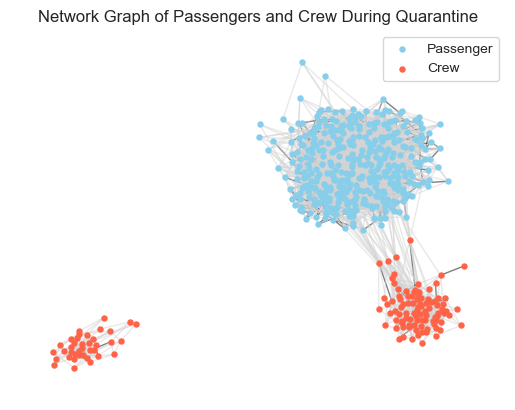

In [14]:
import matplotlib.pyplot as plt

sample_nodes = random.sample(list(G.nodes()), 500)
H = G.subgraph(sample_nodes)

passengers = [n for n in H.nodes if G.nodes[n]['type'] == 'passenger']
crew = [n for n in H.nodes if G.nodes[n]['type'] == 'crew']

more_w = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] > 0.5]
less_w = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] <= 0.5]

pos = nx.spring_layout(H, seed=42)
nx.draw_networkx_nodes(H, pos, nodelist=passengers, node_color='skyblue', label='Passenger', node_size=13)
nx.draw_networkx_nodes(H, pos, nodelist=crew, node_color='tomato', label='Crew', node_size=13)
nx.draw_networkx_edges(H, pos, edgelist=more_w, edge_color='black', alpha=0.5)
nx.draw_networkx_edges(H, pos, edgelist=less_w, edge_color='lightgray', alpha=0.5)
plt.legend()
plt.title('Network Graph of Passengers and Crew During Quarantine')
plt.axis('off')
plt.show()

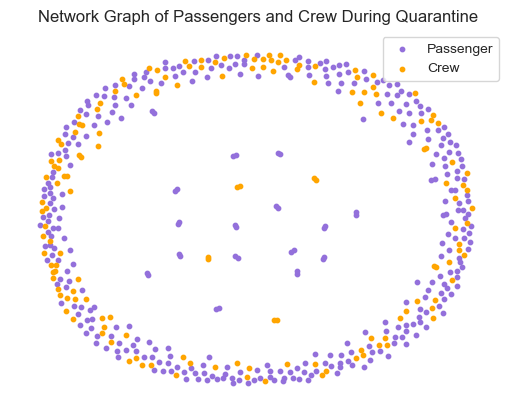

In [15]:
# checking G_Quarntine
sample_nodes_GQ = random.sample(list(G_Q.nodes()), 500)
H_Q = G_Q.subgraph(sample_nodes_GQ)

passengers_Q = [n for n in H_Q.nodes if G_Q.nodes[n]['type'] == 'passenger']
crew_Q = [n for n in H_Q.nodes if G_Q.nodes[n]['type'] == 'crew']

pos = nx.spring_layout(H_Q, seed=42)
nx.draw_networkx_nodes(H_Q, pos, nodelist=passengers_Q, node_color='mediumpurple', label='Passenger', node_size=10)
nx.draw_networkx_nodes(H_Q, pos, nodelist=crew_Q, node_color='orange', label='Crew', node_size=10)
nx.draw_networkx_edges(H_Q, pos, alpha=0.1)
plt.legend()
plt.title('Network Graph of Passengers and Crew During Quarantine')
plt.axis('off')
plt.show()

In [16]:
from seirsplus.models import SEIRSNetworkModel
import numpy as np

N = G.number_of_nodes()

np.random.seed(123)
incubation_times = np.random.lognormal(mean=1.63, sigma=0.5, size=N)
sigma = 1/np.mean(incubation_times)

BETA     = 0.8
SIGMA    = sigma
GAMMA    = 1/7
MU_I     = 0.03
P     = 0.74 
G_quarantine = G_Q
BETA_Q      = 0.01
SIGMA_Q     = SIGMA
GAMMA_Q     = GAMMA
Q           = 0


theta_E = 0.1
theta_I = 0.2


In [17]:
model = SEIRSNetworkModel(
    G       = G,
    beta    = BETA,
    sigma   = SIGMA,
    gamma   = GAMMA,
    mu_I    = MU_I,
    mu_0    = 0,
    nu      = 0,
    xi      = 0,
    p       = P,
    G_Q     = G_quarantine,
    beta_Q  = BETA_Q,
    sigma_Q = SIGMA_Q,
    gamma_Q = GAMMA_Q,
    mu_Q    = MU_I,
    theta_E = 0,
    theta_I = 0,
    phi_E   = 0,
    phi_I   = 0,
    psi_E   = 1.0,
    psi_I   = 1.0,
    q       = Q,
    initI   = 100,
    initE   = 0,
    initQ_E = 0,
    initQ_I = 0,
    initR   = 0,
    initF   = 0
)

checkpoints = {'t': [5, 10],
               'q': [0, 1],              
            'beta': [BETA * 0.5, BETA_Q], 
            'theta_E':[theta_E, 0.4],       
            'theta_I': [theta_I, 0.6] 
              }

/opt/anaconda3/lib/python3.11/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


t = 0.00
t = 10.00
t = 20.00
t = 30.00
t = 40.03
t = 50.09


/opt/anaconda3/lib/python3.11/site-packages/seirsplus/models.py:1562: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


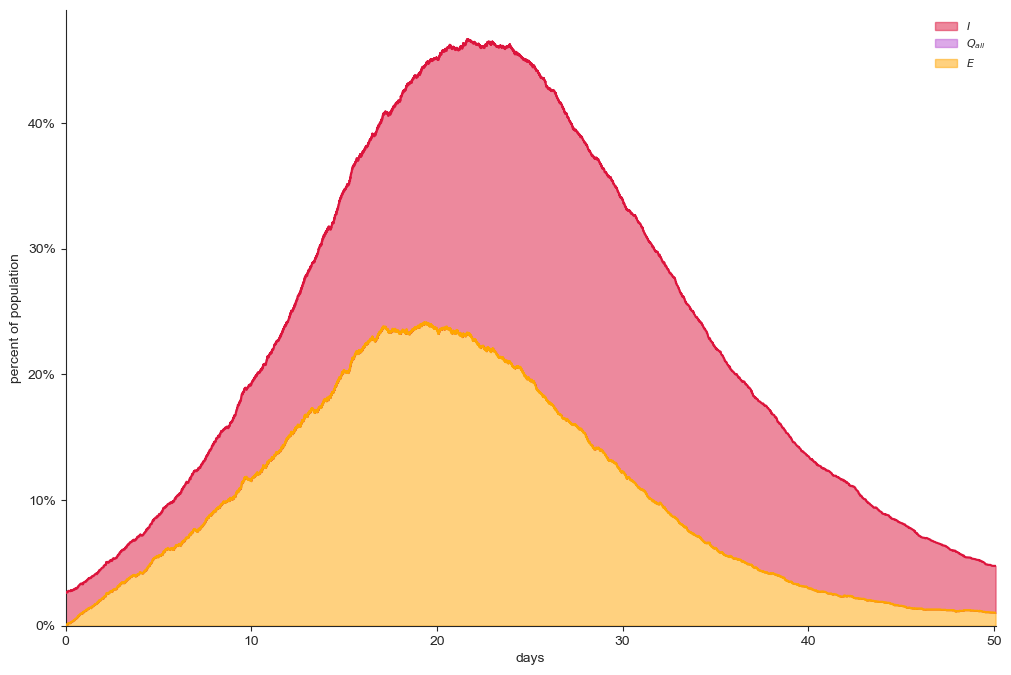

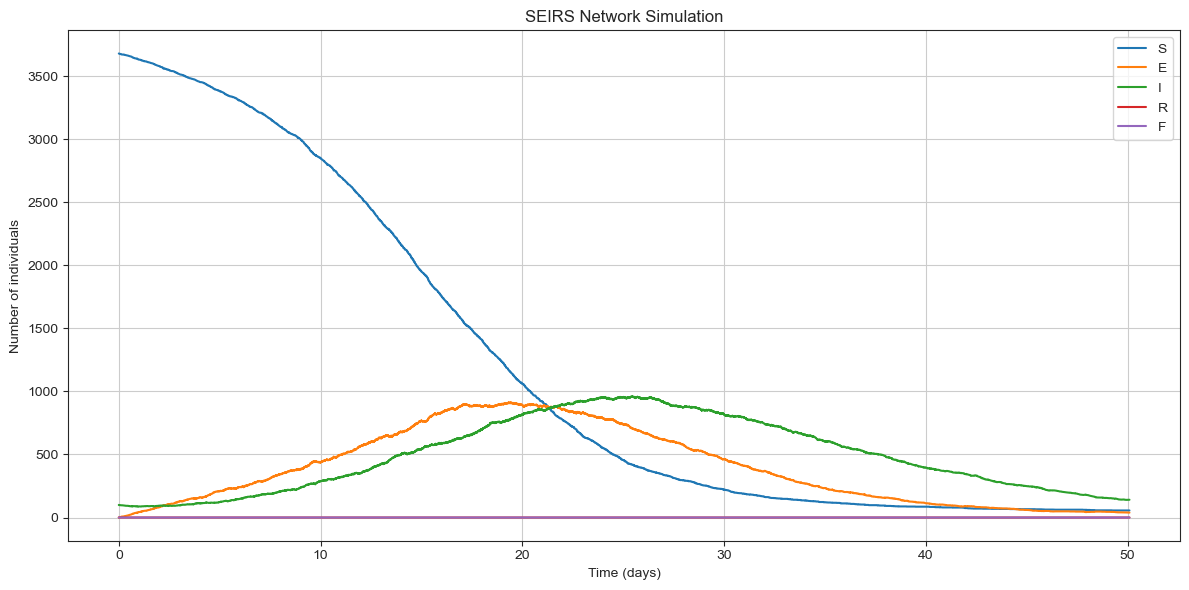

In [18]:
model.run(T=50)
model.figure_infections()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(model.tseries, model.numS, label='S')
plt.plot(model.tseries, model.numE, label='E')
plt.plot(model.tseries, model.numI, label='I')
plt.plot(model.tseries, model.numR, label='R')
plt.plot(model.tseries, model.numF, label='F')

plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.title('SEIRS Network Simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

t = 50.11
t = 60.09
t = 70.08
t = 80.10


/opt/anaconda3/lib/python3.11/site-packages/seirsplus/models.py:1562: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


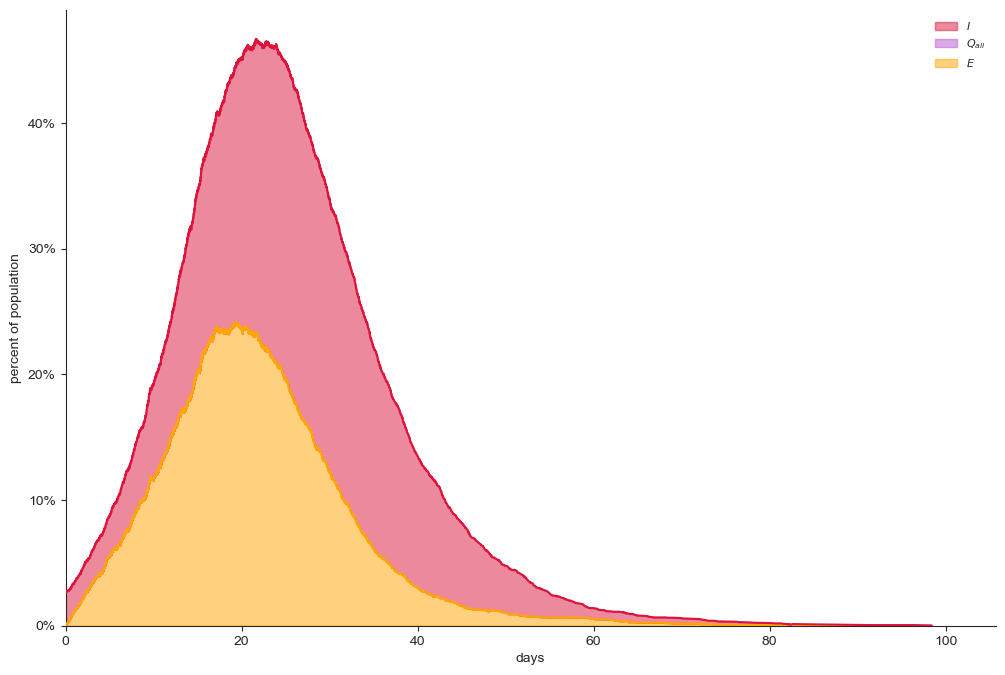

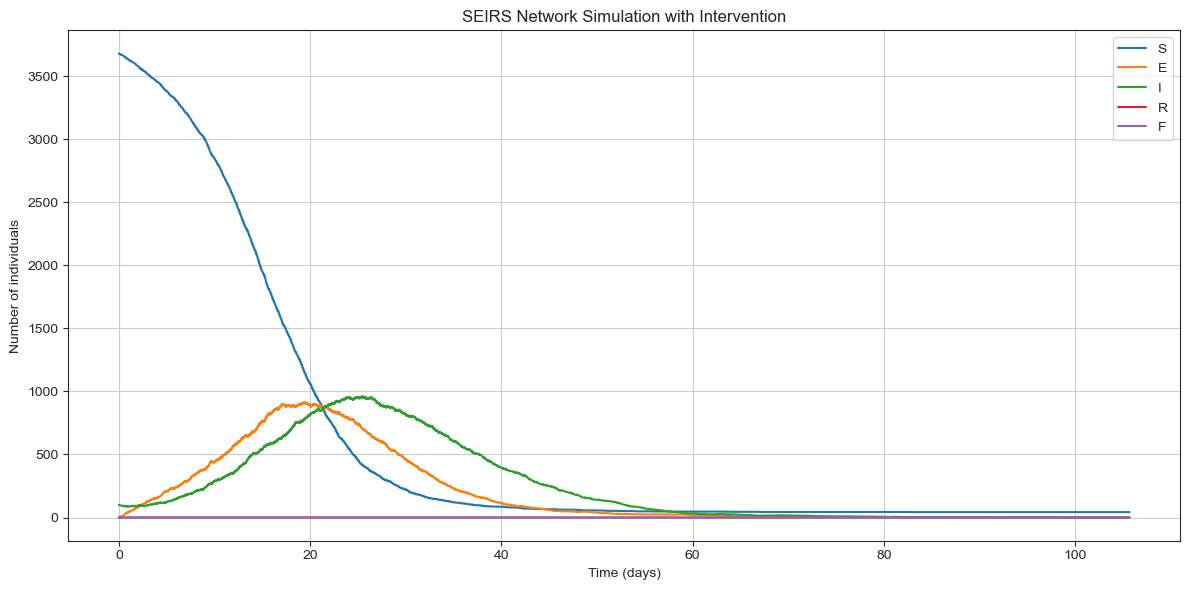

In [19]:
model.run(T=50, checkpoints=checkpoints)
model.figure_infections()


plt.figure(figsize=(12,6))
plt.plot(model.tseries, model.numS, label='S')
plt.plot(model.tseries, model.numE, label='E')
plt.plot(model.tseries, model.numI, label='I')
plt.plot(model.tseries, model.numR, label='R')
plt.plot(model.tseries, model.numF, label='F')

plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.title('SEIRS Network Simulation with Intervention')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import pandas as pd

time = model.tseries
S = model.numS
E = model.numE
I = model.numI
R = model.numR
F = model.numF

df = pd.DataFrame({
    'Day'        : time,
    'Susceptible': S,
    'Exposed'    : E,
    'Infectious' : I,
    'Recovered'  : R,
    'Fatalities' : F
})

print(df)

              Day  Susceptible  Exposed  Infectious  Recovered  Fatalities
0        0.000000       3680.0      0.0       100.0        0.0         0.0
1        0.000096       3680.0      0.0        99.0        0.0         0.0
2        0.036468       3679.0      1.0        99.0        0.0         0.0
3        0.040040       3678.0      2.0        99.0        0.0         0.0
4        0.045460       3678.0      2.0        98.0        0.0         0.0
...           ...          ...      ...         ...        ...         ...
11007   88.658404         43.0      1.0         2.0        0.0         0.0
11008   91.096393         43.0      1.0         1.0        0.0         0.0
11009   96.222763         43.0      0.0         2.0        0.0         0.0
11010   98.418229         43.0      0.0         1.0        0.0         0.0
11011  105.669717         43.0      0.0         0.0        0.0         0.0

[11012 rows x 6 columns]
